In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.ticker as mtick
import asyncio
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import time as t
import threading
import requests
from requests import Request, Session
import datetime
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import hvplot.pandas
from panel.interact import interact
from panel import widgets
import plotly.express as px
import panel as pn

In [3]:
# This regularly crashes the first time run but works when run a second time...

import mplfinance as mf

### ___Define a function that interacts w API and creates token dataframe;___

In [4]:
def kucoin_func(ticker):
    # Request data from api
    crypto = requests.get(f'https://api.kucoin.com/api/v1/market/candles?type=1day&symbol={ticker}-USDT&startAt=1620360000&endAt=0&limit=1000')
    
    # Import api data as json    
    crypto_j = crypto.json()
    
    # Create pandas df from json file    
    crypto_df = pd.DataFrame(crypto_j['data'])
    
    # Rename columns appropriately for later mplfinance processing
    crypto_df.rename(columns={0:'Dates',1:'Open',2:'Close',3:'High',4:'Low',6:'Volume'}, inplace=True)
    
    # Drop excess data
    crypto_df.drop(columns=5,inplace=True)
    
    # Reorder columns for mplfinance
    crypto_df = crypto_df[['Dates','Open','High','Low','Close','Volume']]
    
    # Create dataframe with converted datetime for column 'Dates'
    crypto_df_dates = pd.to_datetime(crypto_df['Dates'], unit='s')
    
    # Drop unformatted date column from primary dataframe
    crypto_df = crypto_df[['Open','High','Low','Close','Volume']]
    
    # Ensure data in OHLCV columns are floats
    crypto_df = crypto_df[['Open','High','Low','Close','Volume']].astype(float)
    
    # Concatenate 'Date' dataframe with 'OHLCV' dataframe
    crypto_frame = pd.concat([crypto_df_dates,crypto_df], axis = 1, join = 'inner')
    
    #Set index to 'Dates'
    crypto_frame.set_index('Dates',inplace=True)
    
    return crypto_frame

def binance_func(ticker):
    # Request data from api
    crypto = requests.get(f'https://api.binance.com/api/v3/klines?symbol={ticker}USDT&interval=1d&startTime=1620360000000&limit=1000')
    
    # Import api data as json    
    crypto_j = crypto.json()
    
    # Create pandas df from json file    
    crypto_df = pd.DataFrame(crypto_j)
    
    # Rename columns appropriately for later mplfinance processing
    crypto_df.rename(columns={0:'Dates',1:'Open',2:'High',3:'Low',4:'Close',7:'Volume'}, inplace=True)
    
    # Drop excess data
    crypto_df.drop(columns= [5,6,8,9,10,11], inplace=True)
    
    # Reorder columns for mplfinance
    crypto_df = crypto_df[['Dates','Open','High','Low','Close','Volume']]
    
    # Create dataframe with converted datetime for column 'Dates'
    crypto_df_dates = pd.to_datetime(crypto_df['Dates'], unit='ms')
    
    # Drop unformatted date column from primary dataframe
    crypto_df = crypto_df[['Open','High','Low','Close','Volume']]
    
    # Ensure data in OHLCV columns are floats
    crypto_df = crypto_df[['Open','High','Low','Close','Volume']].astype(float)
    
    # Concatenate 'Date' dataframe with 'OHLCV' dataframe
    crypto_frame = pd.concat([crypto_df_dates,crypto_df], axis = 1, join = 'inner')
    
    #Set index to 'Dates'
    crypto_frame.set_index('Dates',inplace=True)
    
    return crypto_frame

### ___Create list containing tickers to be used in token index___

In [5]:
base_tokens = {'kucoin_tokens':['BTC','DOT','ETH','ADA','DOGE','LTC','BNB','XRP','UNI','LINK','USDC','LUNA','AVAX','ALGO','BCH','VET','XLM'],
          'binance_tokens':['SOL','MATIC']}

### ___Create Dictionary containing portfolio weights___

In [6]:
base_weights = {'BTC' : 0.42983,
                            'DOT' : 0.0159,
                            'ETH' : 0.193,
                            'ADA' : 0.024,
                            'DOGE' : 0.0121,
                            'LTC' : 0.0065,
                            'BNB' : 0.0378,
                            'XRP' : 0.0199,
                            'UNI' : 0.00661,
                            'LINK' : 0.00661,
                            'USDC' : 0.0262,
                            'LUNA' : 0.00776,
                            'AVAX' : 0.0075,
                            'ALGO' : 0.0043,
                            'BCH' : 0.0045,
                            'VET' : 0.0038,
                            'XLM' : 0.0033,
                            'SOL': 0.0258,
                            'MATIC': 0.0043}

#### ___Create 'for loop' to call function for each token that combines data into one dataframe with weighted OHLC values and summed volume___

In [10]:
# Declare necessary empty dictionaries and lists
func = {}
w_sum = {}
base_ohlc = pd.DataFrame()
base_vol = pd.DataFrame()

#Loop
for x in base_tokens:
    
# Run function for each token in list and add to func dictionary
    for y in base_tokens['kucoin_tokens']:
     
        func[y] = pd.DataFrame(kucoin_func(y)).iloc[::-1]
        
    for z in base_tokens['binance_tokens']:
        func[z] = pd.DataFrame(binance_func(z))
        
    for x in base_weights:
        w_sum[x] = func[x][['Open','High','Low','Close']]*base_weights[x]
    
        # Create summary dataframe for OHLC data
        base_ohlc = base_ohlc.add(w_sum[x][['Open','High','Low','Close']], fill_value = 0)
    
        # Create summary dataframe for Volume data
        base_vol = base_vol.add(func[x][['Volume']], fill_value=0)

In [12]:
ohlc_norm = pd.DataFrame(((base_ohlc-(base_ohlc.iloc[0]))/base_ohlc.iloc[0])*100)
ohlc_vol = [ohlc_norm,base_vol]
base_frame = pd.concat(ohlc_vol, axis=1, join = 'inner')
base_frame

,Open,High,Low,Close,Volume
Dates,,,,,
2021-05-08,0.000000,0.000000,0.000000,0.000000,3.632547e+09
2021-05-09,2.972234,-0.438173,-0.954095,-0.996111,5.945217e+09
2021-05-10,1.946697,0.205547,-7.362797,-5.001638,4.973461e+09
2021-05-11,-2.179115,-4.129180,-3.994621,-3.397644,4.391867e+09
2021-05-12,-0.526532,-2.134618,-14.421198,-15.247269,6.678907e+09
...,...,...,...,...,...
2021-11-13,12.490836,9.471780,11.903420,9.623165,2.310230e+09
2021-11-14,12.881382,10.358144,12.193779,11.479632,2.325877e+09
2021-11-15,14.792888,11.797990,11.878485,8.310168,3.282349e+09


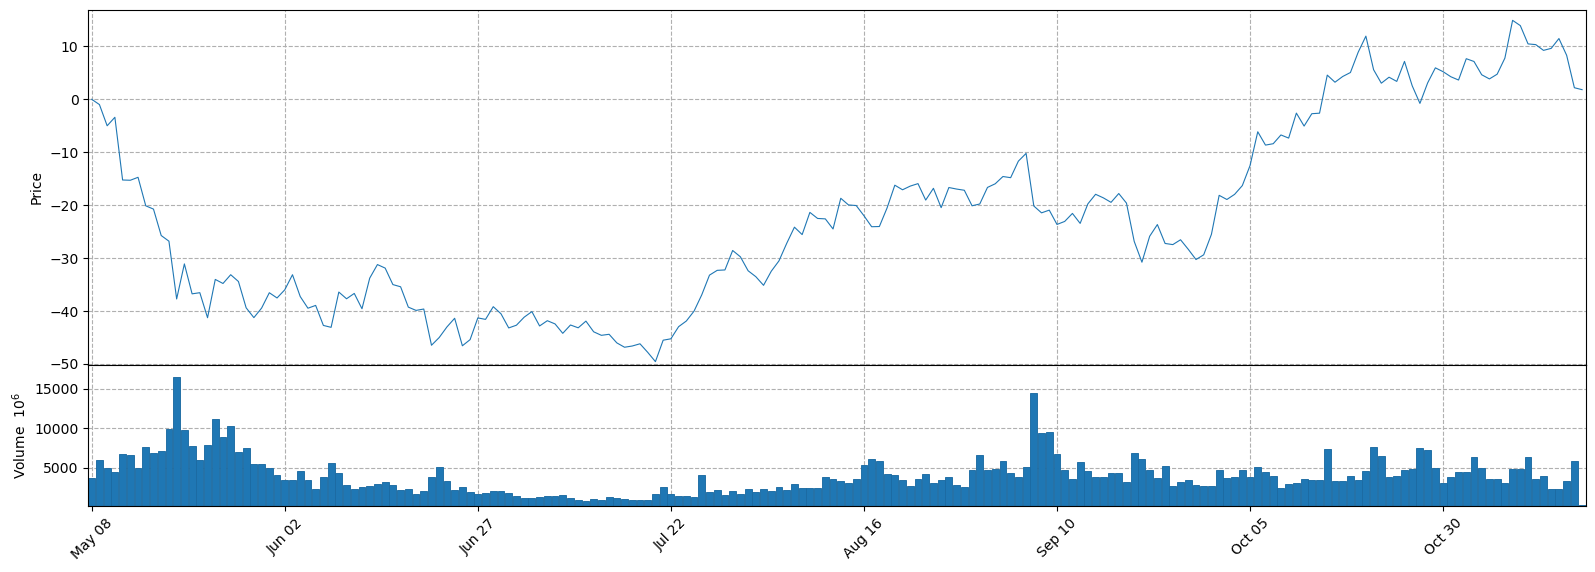

In [13]:
mc = mf.make_marketcolors(up='g',down='r')
s  = mf.make_mpf_style(marketcolors=mc, gridstyle='dashed')
mf.plot(base_frame, type='line', volume=True, figratio=(30,10), style=s, tight_layout=True)

In [16]:
mgn_tokens = { 'kucoin_tokens':['DOGE', 'MANA', 'ENJ', 'SAND', 'CHZ', 'DGB'],
           'binance_tokens':['AXS', 'THETA', 'XTZ']}

In [17]:
mgn_weights = {
        'DOGE' : 0.0121,
        'MANA' : 0.00217,
        'ENJ' : 0.00091,
        'SAND' : 0.00093,
        'CHZ' : 0.0011,
        'DGB' : 0.00034,
        'AXS' : 0.0031,
        'THETA' : 0.0024,
        'XTZ' : 0.00174
}

In [18]:
# Declare necessary empty dictionaries and lists
func = {}
w_sum = {}
mgn_ohlc = pd.DataFrame()
mgn_vol = pd.DataFrame()

#Loop
for x in mgn_tokens:
    
# Run function for each token in list and add to func dictionary
    for y in mgn_tokens['kucoin_tokens']:
     
        func[y] = pd.DataFrame(kucoin_func(y)).iloc[::-1]
        
    for z in mgn_tokens['binance_tokens']:
        func[z] = pd.DataFrame(binance_func(z))
        
    for x in mgn_weights:
        w_sum[x] = func[x][['Open','High','Low','Close']]*mgn_weights[x]
    
        # Create summary dataframe for OHLC data
        mgn_ohlc = mgn_ohlc.add(w_sum[x][['Open','High','Low','Close']], fill_value = 0)
    
        # Create summary dataframe for Volume data
        mgn_vol = mgn_vol.add(func[x][['Volume']], fill_value=0)

In [19]:
ohlc_norm = pd.DataFrame(((mgn_ohlc-(mgn_ohlc.iloc[0]))/mgn_ohlc.iloc[0])*100)
ohlc_vol = [ohlc_norm,mgn_vol]
mgn_frame = pd.concat(ohlc_vol, axis=1, join = 'inner')
mgn_frame

,Open,High,Low,Close,Volume
Dates,,,,,
2021-05-08,0.000000,0.000000,0.000000,0.000000,1.545690e+09
2021-05-09,0.725741,-3.189542,-5.811856,-2.370893,1.595961e+09
2021-05-10,-1.626859,-7.784880,-17.633683,-14.684194,9.948093e+08
2021-05-11,-14.110457,-11.404684,-14.105863,-7.040863,9.247688e+08
2021-05-12,-6.367769,-7.621986,-21.477244,-22.128766,9.435047e+08
...,...,...,...,...,...
2021-11-13,503.345913,472.135593,517.190620,497.128822,7.713573e+08
2021-11-14,501.729482,465.329202,508.914358,495.114859,4.624310e+08
2021-11-15,499.383422,466.556831,513.375812,494.752561,5.107575e+08


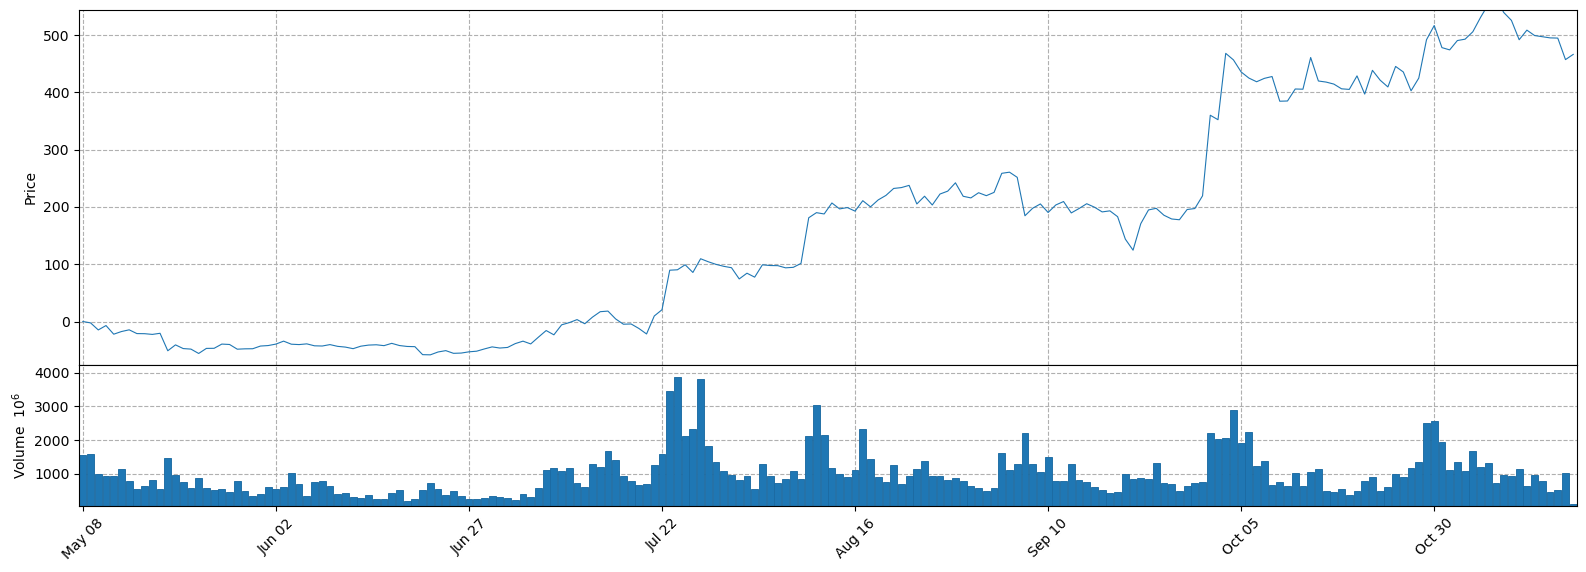

In [21]:
# index_returns_norm = pd.DataFrame(((index_returns-(index_returns[0]))/index_returns[0])*100)
mgn_frame_norm = pd.DataFrame(((mgn_frame-(mgn_frame.iloc[0]))/mgn_frame.iloc[0])*100)
mgn_frame_norm

mc = mf.make_marketcolors(up='g',down='r')
s  = mf.make_mpf_style(marketcolors=mc, gridstyle='dashed')
mf.plot(mgn_frame, type='line', volume=True, figratio=(30,10), style=s, tight_layout=True)

In [22]:
fin_tokens = {'kucoin_tokens':['XRP','XLM','XDC','XTZ','LTC','BCH'],
          'binance_tokens':['HBAR']}

In [23]:
fin_weights = {'XRP' : 0.0199,
                            'XLM' : 0.0033,
                            'XDC' : 0.0004,
                            'XTZ' : 0.0018,
                            'LTC' : 0.0065,
                            'BCH' : 0.0045,
                            'HBAR': 0.0023}

In [24]:
# Declare necessary empty dictionaries and lists
func = {}
w_sum = {}
fin_ohlc = pd.DataFrame()
fin_vol = pd.DataFrame()

#Loop
for x in fin_tokens:
    
# Run function for each token in list and add to func dictionary
    for y in fin_tokens['kucoin_tokens']:
     
        func[y] = pd.DataFrame(kucoin_func(y)).iloc[::-1]
        
    for z in fin_tokens['binance_tokens']:
        func[z] = pd.DataFrame(binance_func(z))
        
    for x in fin_weights:
        w_sum[x] = func[x][['Open','High','Low','Close']]*fin_weights[x]
    
        # Create summary dataframe for OHLC data
        fin_ohlc = fin_ohlc.add(w_sum[x][['Open','High','Low','Close']], fill_value = 0)
    
        # Create summary dataframe for Volume data
        fin_vol = fin_vol.add(func[x][['Volume']], fill_value=0)

In [25]:
ohlc_norm = pd.DataFrame(((fin_ohlc-(fin_ohlc.iloc[0]))/fin_ohlc.iloc[0])*100)
ohlc_vol = [ohlc_norm,fin_vol]
fin_frame = pd.concat(ohlc_vol, axis=1, join = 'inner')
fin_frame

,Open,High,Low,Close,Volume
Dates,,,,,
2021-05-08,0.000000,0.000000,0.000000,0.000000,3.763361e+08
2021-05-09,3.249830,1.456395,-2.307541,4.733054,4.429553e+08
2021-05-10,8.147942,10.422877,-6.888238,-3.175666,8.074309e+08
2021-05-11,-0.100756,6.800305,-0.352352,10.229045,5.759271e+08
2021-05-12,13.861176,12.468048,-10.067965,-12.424493,7.266367e+08
...,...,...,...,...,...
2021-11-13,-43.800338,-46.282042,-43.995783,-45.169812,2.825686e+08
2021-11-14,-43.400344,-44.705787,-43.571206,-42.855095,2.836138e+08
2021-11-15,-40.988998,-44.209745,-42.340275,-44.832670,3.481317e+08


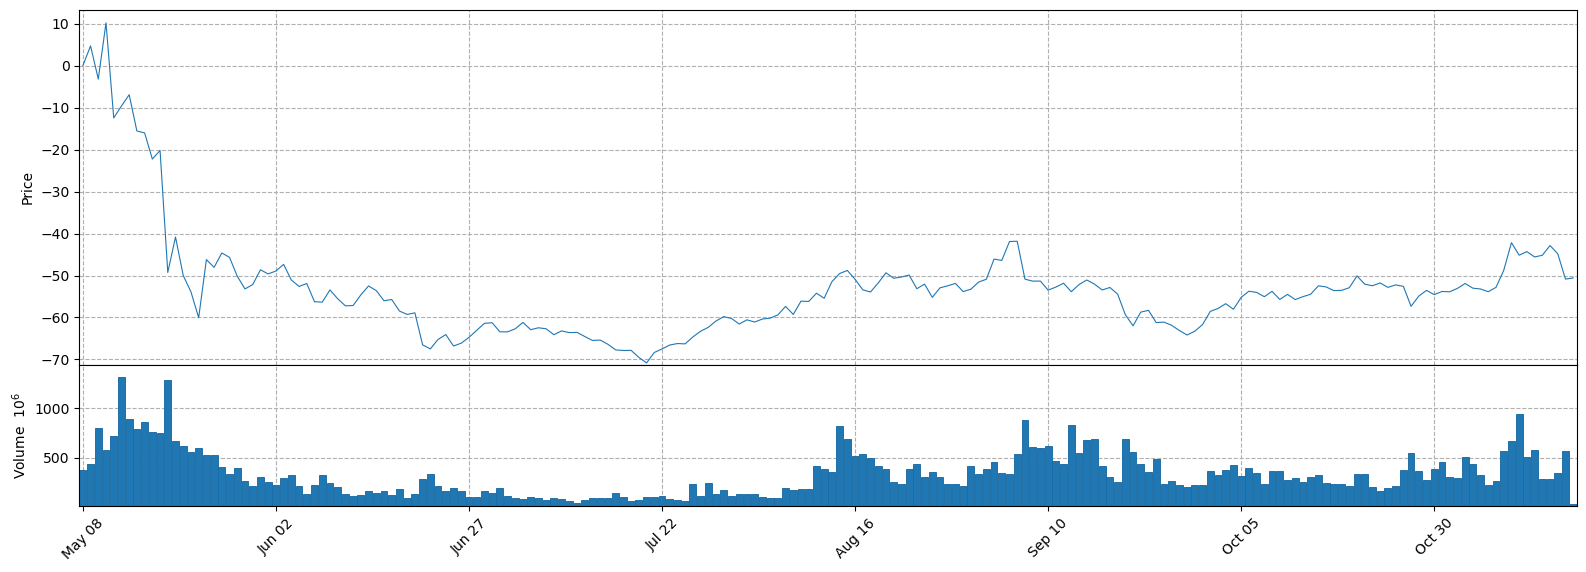

In [26]:
# index_returns_norm = pd.DataFrame(((index_returns-(index_returns[0]))/index_returns[0])*100)
fin_frame_norm = pd.DataFrame(((fin_frame-(fin_frame.iloc[0]))/fin_frame.iloc[0])*100)
fin_frame_norm

mc = mf.make_marketcolors(up='g',down='r')
s  = mf.make_mpf_style(marketcolors=mc, gridstyle='dashed')
mf.plot(fin_frame, type='line', volume=True, figratio=(30,10), style=s, tight_layout=True)

In [27]:
defi_tokens = {'kucoin_tokens':['AVAX','LINK','UNI','COMP','LUNA','ALGO'],
          'binance_tokens':['MATIC']}

In [28]:
defi_weights = {'AVAX' : 0.0076,
                            'LINK': 0.0056,
                            'UNI' : 0.0055,
                            'COMP': 0.0073,
                            'LUNA': 0.0085,
                            'ALGO': 0.0046,
                            'MATIC': 0.0043}

In [29]:
# Declare necessary empty dictionaries and lists
func = {}
w_sum = {}
defi_ohlc = pd.DataFrame()
defi_vol = pd.DataFrame()

#Loop
for x in defi_tokens:
    
# Run function for each token in list and add to func dictionary
    for y in defi_tokens['kucoin_tokens']:
     
        func[y] = pd.DataFrame(kucoin_func(y)).iloc[::-1]
        
    for z in defi_tokens['binance_tokens']:
        func[z] = pd.DataFrame(binance_func(z))
        
    for x in defi_weights:
        w_sum[x] = func[x][['Open','High','Low','Close']]*defi_weights[x]
    
        # Create summary dataframe for OHLC data
        defi_ohlc = defi_ohlc.add(w_sum[x][['Open','High','Low','Close']], fill_value = 0)
    
        # Create summary dataframe for Volume data
        defi_vol = defi_vol.add(func[x][['Volume']], fill_value=0)

In [30]:
ohlc_norm = pd.DataFrame(((defi_ohlc-(defi_ohlc.iloc[0]))/defi_ohlc.iloc[0])*100)
ohlc_vol = [ohlc_norm,defi_vol]
defi_frame = pd.concat(ohlc_vol, axis=1, join = 'inner')
defi_frame

,Open,High,Low,Close,Volume
Dates,,,,,
2021-05-08,0.000000,0.000000,0.000000,0.000000,5.092552e+08
2021-05-09,8.343478,-1.720693,3.110380,-0.795664,2.105330e+09
2021-05-10,7.199435,1.502736,-1.512370,-0.924336,9.601461e+08
2021-05-11,7.043526,6.858650,6.926395,7.686830,1.046885e+09
2021-05-12,16.383468,12.224196,0.087719,-6.849079,1.931877e+09
...,...,...,...,...,...
2021-11-13,-38.291743,-39.322301,-37.493581,-38.006873,3.991119e+08
2021-11-14,-33.042781,-38.707267,-35.323762,-39.342914,3.852565e+08
2021-11-15,-34.446065,-39.172007,-36.437049,-41.598703,4.464619e+08


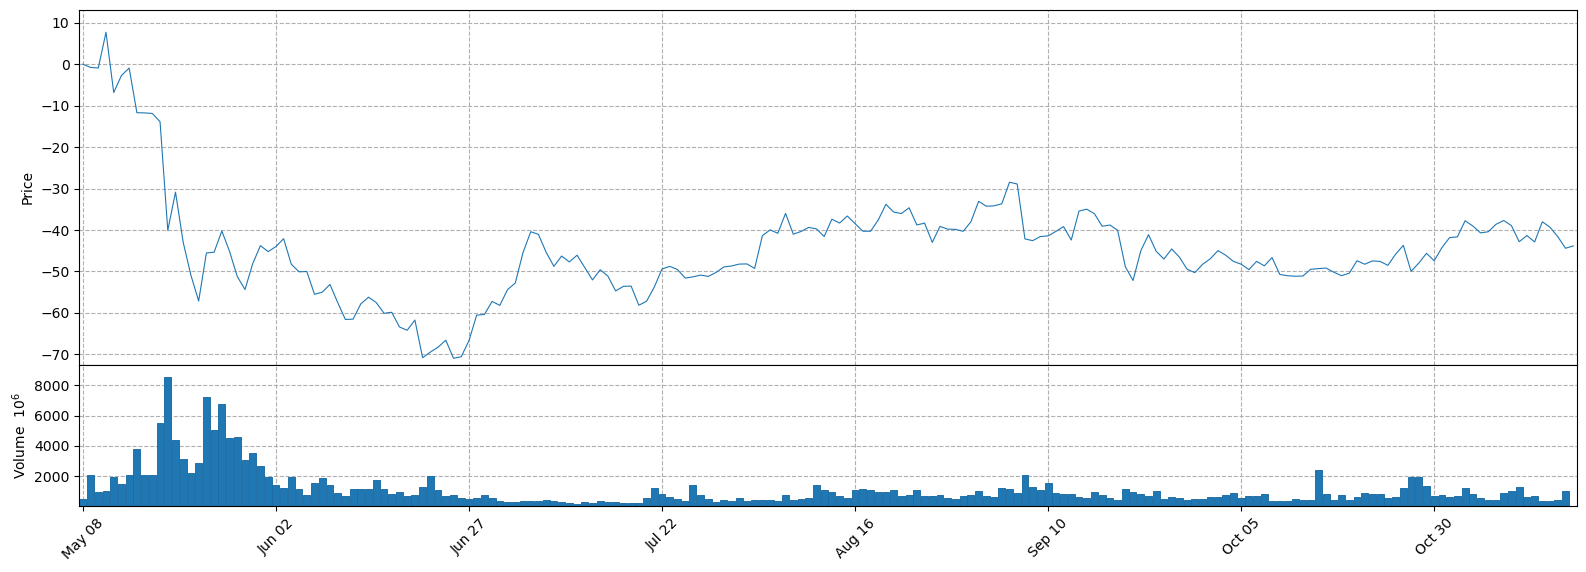

In [31]:
# index_returns_norm = pd.DataFrame(((index_returns-(index_returns[0]))/index_returns[0])*100)
defi_frame_norm = pd.DataFrame(((defi_frame-(defi_frame.iloc[0]))/defi_frame.iloc[0])*100)
defi_frame_norm

mc = mf.make_marketcolors(up='g',down='r')
s  = mf.make_mpf_style(marketcolors=mc, gridstyle='dashed')
mf.plot(defi_frame, type='line', volume=True, figratio=(30,10), style=s, tight_layout=True)